<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Residual-taxa" data-toc-modified-id="Residual-taxa-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Residual taxa</a></span></li><li><span><a href="#Investigate-top-taxa-present-in-both-Combined-and-PTHS" data-toc-modified-id="Investigate-top-taxa-present-in-both-Combined-and-PTHS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Investigate top taxa present in both Combined and PTHS</a></span></li><li><span><a href="#Investigate-taxonomies" data-toc-modified-id="Investigate-taxonomies-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Investigate taxonomies</a></span><ul class="toc-item"><li><span><a href="#Common-taxa-between-Combined-and-PTHS" data-toc-modified-id="Common-taxa-between-Combined-and-PTHS-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Common taxa between Combined and PTHS</a></span></li><li><span><a href="#Taxa-unique-to-PTHS" data-toc-modified-id="Taxa-unique-to-PTHS-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Taxa unique to PTHS</a></span></li></ul></li><li><span><a href="#Metabolic-pathway-analysis" data-toc-modified-id="Metabolic-pathway-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Metabolic pathway analysis</a></span><ul class="toc-item"><li><span><a href="#Combined-KEGGs" data-toc-modified-id="Combined-KEGGs-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Combined KEGGs</a></span></li><li><span><a href="#PTHS-KEGGs" data-toc-modified-id="PTHS-KEGGs-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>PTHS KEGGs</a></span></li></ul></li><li><span><a href="#PTHS-unique-KEGGs" data-toc-modified-id="PTHS-unique-KEGGs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PTHS unique KEGGs</a></span></li><li><span><a href="#Combined-unique-KEGGs" data-toc-modified-id="Combined-unique-KEGGs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Combined unique KEGGs</a></span></li><li><span><a href="#Pairwise-WGS-analysis" data-toc-modified-id="Pairwise-WGS-analysis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Pairwise WGS analysis</a></span></li><li><span><a href="#Dan-debug" data-toc-modified-id="Dan-debug-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Dan debug</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr

from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
wgs_directory = '../sfari/data/sra_shotgun/Combined'
pths_directory = '../sfari/data/sra_shotgun/PTHS'
taxa_directory = '~/databases/wol/taxonomy'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

In [3]:
wgs_fname = f'{wgs_directory}/age_sex_matched_posterior/ogus_differentials-v3.nc'
wgs_diffs = extract_differentials(wgs_fname)
pths_fname = f'{pths_directory}/age_sex_matched_posterior/ogus_differentials-v2.nc'
pths_diffs = extract_differentials(pths_fname)

wgs_stats = ranking(wgs_diffs, reference_percentile=95)
pths_stats = ranking(pths_diffs, reference_percentile=95)

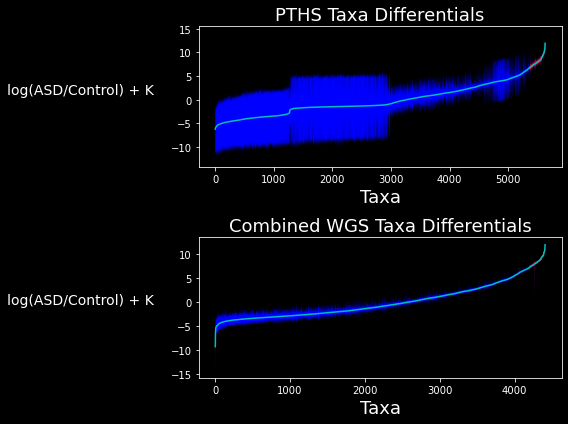

In [4]:
# Plot the log-fold changes
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    rankplot(pths_stats, ax[0])
    ax[0].set_title('PTHS Taxa Differentials', 
                    fontsize=18)
    ax[0].set_xlabel('Taxa', fontsize=18)
    rankplot(wgs_stats, ax[1])
    ax[1].set_title('Combined WGS Taxa Differentials', 
                    fontsize=18)
    ax[1].set_xlabel('Taxa', fontsize=18)
    plt.tight_layout()

In [5]:
# Perform Bayesian hypothesis test
from q2_matchmaker._stats import spherical_test
w_pths, pths_r, pths_z = spherical_test(pths_diffs.values.T, p=1)
w_wgs, wgs_r, wgs_z = spherical_test(wgs_diffs.values.T, p=1)


print(f'[WGS] ASD diff detected {not w_wgs}, '
      f'Effect size {wgs_z / wgs_r}')
print(f'[PTHS] ASD diff detected {not w_pths}, '
      f'Effect size {pths_z / pths_r}')

[WGS] ASD diff detected True, Effect size 13.877050149887204
[PTHS] ASD diff detected True, Effect size 2.359513461806602


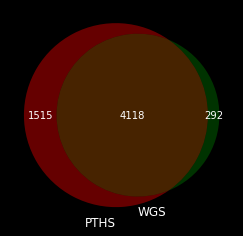

In [6]:
# Venn diagram to visualize overlap
with plt.style.context('dark_background'):
    venn2([set(pths_stats.index), 
           set(wgs_stats.index)], 
          set_labels=['PTHS', 'WGS'])

In [7]:
common_taxa = list(set(pths_stats.index) & set(wgs_stats.index))
common_taxa.sort()

In [8]:
len(common_taxa)

4118

In [9]:
def overlap_f(x, y, q=100):
    x_thres = np.percentile(x.values, q)
    y_thres = np.percentile(y.values, q)
    x_set = set(x.loc[x > x_thres].index)
    y_set = set(y.loc[y > y_thres].index)
    # print(x_thres, y_thres, len(x_set & y_set), len(x_set), len(y_set))
    return len(x_set & y_set) / len(x_set)

spacing = np.linspace(0, 99, 50)
overlaps = [overlap_f(wgs_stats['mean'], pths_stats['mean'], q) for q in spacing]

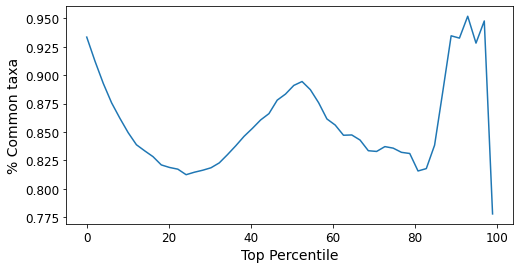

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(spacing, overlaps)
ax.set_xlabel('Top Percentile', fontsize=14)
ax.set_ylabel('% Common taxa', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

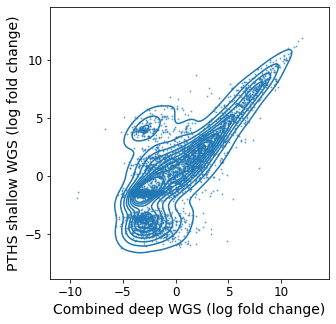

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
common_data = pd.DataFrame({
    'WGS' : wgs_stats.loc[common_taxa, 'mean'],
    'PTHS' : pths_stats.loc[common_taxa, 'mean']
})
sns.kdeplot(data=common_data, x="WGS", y="PTHS", ax=ax)
ax.scatter(wgs_stats.loc[common_taxa, 'mean'], 
           pths_stats.loc[common_taxa, 'mean'], 
           alpha=0.5, s=1)
ax.set_xlabel('Combined deep WGS (log fold change)', fontsize=14)
ax.set_ylabel('PTHS shallow WGS (log fold change)', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

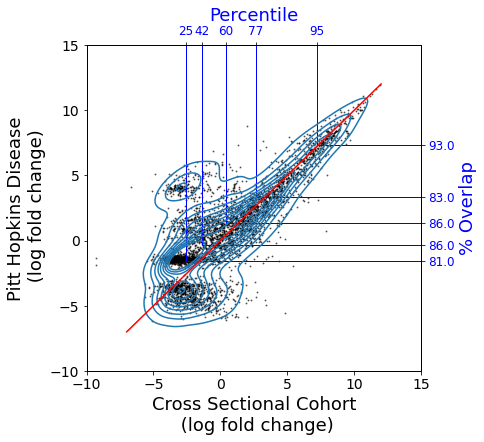

In [12]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(6, 6))
common_data = pd.DataFrame({
    'WGS' : wgs_stats.loc[common_taxa, 'mean'],
    'PTHS' : pths_stats.loc[common_taxa, 'mean']
})

sns.kdeplot(data=common_data, x="WGS", y="PTHS", ax=ax)
ax.scatter(wgs_stats.loc[common_taxa, 'mean'], 
           pths_stats.loc[common_taxa, 'mean'], 
           alpha=0.5, s=1, color='k')
x_min, x_max = -10, 15
y_min, y_max = -10, 15
#x_min = wgs_stats.loc[common_taxa, 'mean'].min()
#y_min = pths_stats.loc[common_taxa, 'mean'].min()
#x_max = wgs_stats.loc[common_taxa, 'mean'].max()
#y_max = pths_stats.loc[common_taxa, 'mean'].max()
spacing = np.linspace(25, 95, 5)
x_thresh = np.percentile(wgs_stats.loc[common_taxa, 'mean'], spacing)
y_thresh = np.percentile(pths_stats.loc[common_taxa, 'mean'], spacing)

for i, s in enumerate(spacing):
    dx, dy = x_max - x_thresh[i], y_max - y_thresh[i]
    poly = Rectangle((x_thresh[i], y_thresh[i]), dx, dy, 
                     fc ='none', 
                     ec ='b',
                     lw = 1)
    ax.add_patch(poly)
    #plt.plot([x_max, x_thresh[i]], [y_thresh[i], y_max], '--b')

overlaps = [overlap_f(wgs_stats['mean'], pths_stats['mean'], q) for q in spacing]
    
ax.set_xlabel('Cross Sectional Cohort\n (log fold change)', fontsize=18)
ax.set_ylabel('Pitt Hopkins Disease\n (log fold change)', fontsize=18)
ax.plot(np.linspace(-7, 12), np.linspace(-7, 12), 'r')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'b'
# have to set dummy figure to make sure that the scales are correct >:(
ax2.scatter(wgs_stats.loc[common_taxa, 'mean'], 
            pths_stats.loc[common_taxa, 'mean'], 
            alpha=0.5, s=0, color='k')
ax2.set_ylabel('% Overlap', color=color, fontsize=18) 
ax2.set_yticks(y_thresh)
ax2.set_yticklabels(np.round(overlaps, 2) * 100)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
# repeat for x axis
ax3 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax3.scatter(wgs_stats.loc[common_taxa, 'mean'], 
           pths_stats.loc[common_taxa, 'mean'], 
           alpha=0.5, s=0, color='k')
ax3.set_xlabel('Percentile', color=color, fontsize=18) 
ax3.set_xticks(x_thresh)
ax3.set_xticklabels(spacing.astype(np.int64))
ax3.tick_params(axis='x', labelcolor=color, labelsize=12)

#ax.set_xlim([-10, 15])
#ax.set_ylim([-10, 15])
#ax.set_xlim([-10, 15])
#ax.set_ylim([-10, 15])
#ax.set_xlim([-10, 15])
#ax.set_ylim([-10, 15])

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax2.set_xlim([x_min, x_max])
ax2.set_ylim([y_min, y_max])
ax3.set_xlim([x_min, x_max])
ax3.set_ylim([y_min, y_max])

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

In [13]:
pearsonr(wgs_stats.loc[common_taxa, 'mean'], pths_stats.loc[common_taxa, 'mean'])

(0.7639996178541602, 0.0)

In [14]:
(95 - 25) / 15

4.666666666666667

In [15]:
x_max, y_max

(15, 15)

In [16]:
x_thresh

array([-2.59532891, -1.3799356 ,  0.42822559,  2.65650541,  7.23933938])

In [17]:
y_thresh

array([-1.56819224, -0.30837792,  1.3434234 ,  3.33652176,  7.33962201])

In [18]:
ax2.get_yticks()

array([-1.56819224, -0.30837792,  1.3434234 ,  3.33652176,  7.33962201])

# Residual taxa

In [19]:
pths_diffs_aligned = pths_diffs.loc[common_taxa]
wgs_diffs_aligned = wgs_diffs.loc[common_taxa]
pths_clr_diffs = pths_diffs - pths_diffs_aligned.mean(axis=0)
wgs_clr_diffs = wgs_diffs - wgs_diffs_aligned.mean(axis=0)
pths_wgs_diffs = pths_diffs_aligned - wgs_diffs_aligned
pths_wgs_stats = ranking(pths_wgs_diffs, reference_percentile=95)

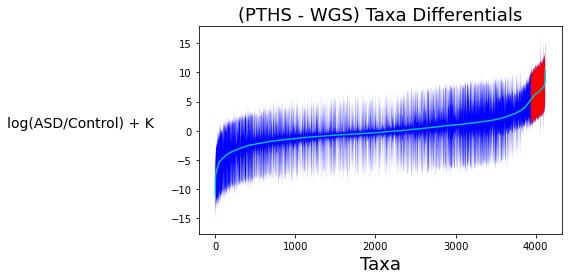

In [20]:
# Plot the log-fold changes
fig, ax = plt.subplots(figsize=(8, 4))
rankplot(pths_wgs_stats, ax)
ax.set_title('(PTHS - WGS) Taxa Differentials', 
                fontsize=18)
ax.set_xlabel('Taxa', fontsize=18)
plt.tight_layout()

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'PTHS - WGS log fold change')

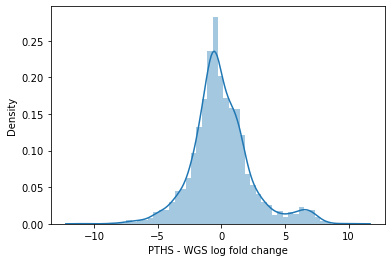

In [21]:
sns.distplot(pths_wgs_stats['mean'])
plt.xlabel('PTHS - WGS log fold change')

In [22]:
np.sum(pths_wgs_stats['mean'] > 0), np.sum(pths_wgs_stats['mean'] < 0)

(1813, 2305)

In [23]:
(pths_wgs_stats.loc[pths_wgs_stats['mean'] < 0, 'mean'].mean(), 
 pths_wgs_stats.loc[pths_wgs_stats['mean'] > 0, 'mean'].mean())

(-1.5510092847743666, 1.9719119698868801)

In [24]:
from scipy.stats import skew, skewtest
skew(pths_wgs_stats['mean'].values)

0.5713135041548156

In [25]:
skew(pths_wgs_diffs.values.ravel())

0.10608876873853605

In [26]:
skewtest(pths_wgs_stats['mean'].values)

SkewtestResult(statistic=13.985792291555121, pvalue=1.9034520179274322e-44)

<AxesSubplot:ylabel='Count'>

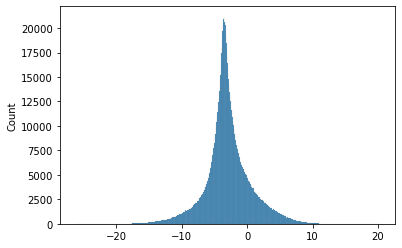

In [27]:
sns.histplot(pths_wgs_diffs.values.ravel())

In [28]:
skewtest(pths_wgs_diffs.values.ravel())

SkewtestResult(statistic=55.43122314510921, pvalue=0.0)

In [29]:
pths_wgs_stats = pths_wgs_stats.sort_values('mean')
wgs_stats = wgs_stats.loc[pths_wgs_stats.index]
pths_stats = pths_stats.loc[pths_wgs_stats.index]

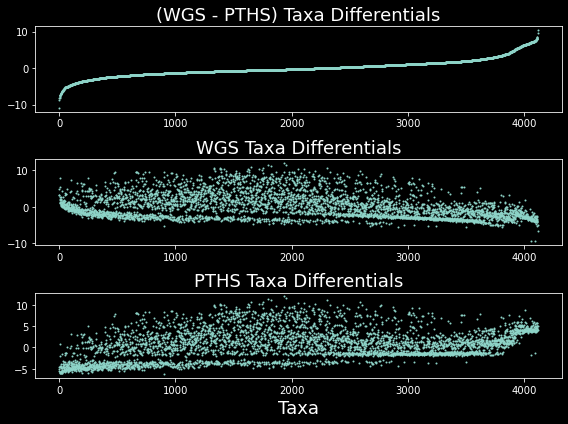

In [30]:
# Plot the log-fold changes
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(3, 1, figsize=(8, 6))
    idx = np.arange(len(pths_wgs_stats))
    ax[0].scatter(idx, pths_wgs_stats['mean'], s=1)
    ax[1].scatter(idx, wgs_stats['mean'], s=1)
    ax[2].scatter(idx, pths_stats['mean'], s=1)

    ax[0].set_title('(WGS - PTHS) Taxa Differentials', 
                    fontsize=18)
    ax[1].set_title('WGS Taxa Differentials', 
                    fontsize=18)
    ax[2].set_title('PTHS Taxa Differentials', 
                    fontsize=18)
    ax[2].set_xlabel('Taxa', fontsize=18)
    plt.tight_layout()

# Investigate top taxa present in both Combined and PTHS

In [31]:
pths_con, pths_asd = select_features(pths_stats, alpha=0.1)
wgs_con, wgs_asd = select_features(wgs_stats, alpha=0.1)

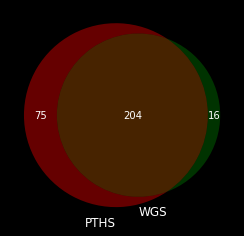

In [32]:
# Venn diagram to visualize overlap
with plt.style.context('dark_background'):
    venn2([set(pths_asd.index), 
           set(wgs_asd.index)], 
          set_labels=['PTHS', 'WGS'])

In [33]:
pths_uniq = list(set(pths_asd.index) - set(wgs_asd.index))
wgs_uniq = list(set(wgs_asd.index) - set(pths_asd.index))
pths_wgs = list(set(pths_asd.index) & set(wgs_asd.index))

# Investigate taxonomies

In [34]:
# Load taxonomies
taxids = pd.read_table(f'{taxa_directory}/taxid.map', header=None, dtype=str)
ranks = pd.read_table(f'{taxa_directory}/ranks.tsv')
taxonomy = pd.merge(ranks, taxids, left_on='genome', right_on=0)
taxonomy = taxonomy.set_index(1)
del taxonomy[0]

## Common taxa between Combined and PTHS

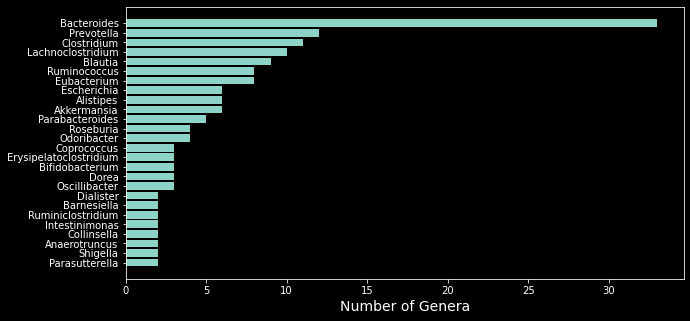

In [35]:
# look at intersection
common_taxa = list(set(taxonomy.index) & set(pths_wgs))
# Visualize KEGG counts for 16S data
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 5))
    taxa_counts = taxonomy.loc[common_taxa, 'genus'].value_counts(ascending=True)
    # only focus on highly representive pathways
    taxa_counts = taxa_counts.loc[taxa_counts > 1] 
    ax.barh(taxa_counts.index, taxa_counts.values)
    ax.set_xlabel('Number of Genera', fontsize=14)

## Taxa unique to PTHS

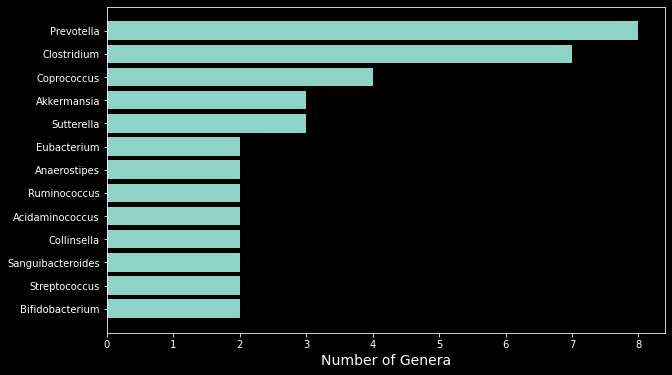

In [36]:
# look at intersection
common_taxa = list(set(taxonomy.index) & set(pths_uniq))
# Visualize KEGG counts for 16S data
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 6))
    taxa_counts = taxonomy.loc[common_taxa, 'genus'].value_counts(ascending=True)
    # only focus on highly representive pathways
    taxa_counts = taxa_counts.loc[taxa_counts > 1] 
    ax.barh(taxa_counts.index, taxa_counts.values)
    ax.set_xlabel('Number of Genera', fontsize=14)

Taxa unique to Combined

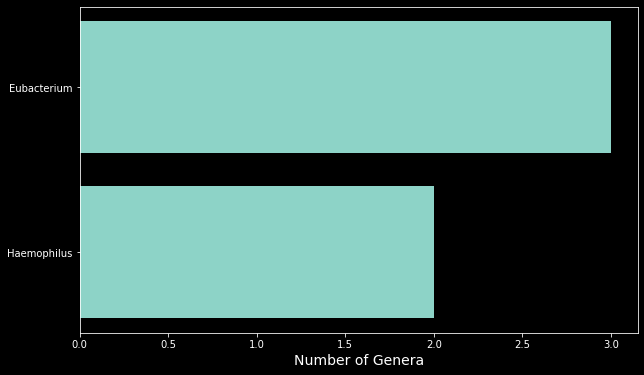

In [37]:
# look at intersection
common_taxa = list(set(taxonomy.index) & set(wgs_uniq))
# Visualize KEGG counts for 16S data
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 6))
    taxa_counts = taxonomy.loc[common_taxa, 'genus'].value_counts(ascending=True)
    # only focus on highly representive pathways
    taxa_counts = taxa_counts.loc[taxa_counts > 1] 
    ax.barh(taxa_counts.index, taxa_counts.values)
    ax.set_xlabel('Number of Genera', fontsize=14)

# Metabolic pathway analysis

## Combined KEGGs

In [38]:
# Perform binomial test on shotgun metagenomics data
# Place hard threshold to select top ASD associated microbes
# Obtain presence-absence tables of microbes and their 
# corresponding KEGG genes in the shotgun data
wgs_con, wgs_asd = select_features(wgs_stats, alpha=0.1)
ko_ogu = get_genomic_data(f'{wgs_directory}/table_func.biom')
kegg_con_wgs = ko_ogu.align(wgs_con, axis=0, join='inner')[0]
kegg_asd_wgs = ko_ogu.align(wgs_asd, axis=0, join='inner')[0]

kegg_con_wgs, kegg_asd_wgs = btest(kegg_con_wgs, kegg_asd_wgs)
kegg_asd_wgs = log_pvalue(kegg_asd_wgs, alpha=0.1)
# apply binomial test.  Use BH correction to get per-gene pvalues
sig_wgs = aggregate_pathways(
    pathway_name_file=f'{kegg_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{kegg_dir}/pathway-to-ko.txt',
    features=kegg_asd_wgs)

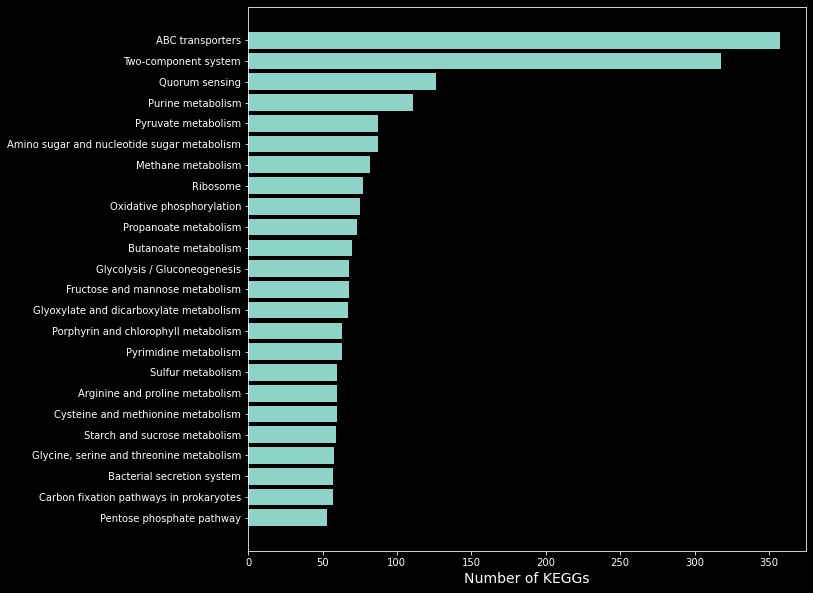

In [39]:
# Visualize KEGG counts for shotgun metagenomics data
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 10))
    pwy_counts = sig_wgs['Name']
    pwy_counts = pwy_counts.value_counts()
    pwy_counts = pwy_counts.sort_values(ascending=True)
    # only focus on highly representive pathways
    pwy_counts = pwy_counts.loc[pwy_counts > 50] 
    ax.barh(pwy_counts.index, pwy_counts.values)
    ax.set_xlabel('Number of KEGGs', fontsize=14)

## PTHS KEGGs

In [40]:
# Perform binomial test on shotgun metagenomics data
# Place hard threshold to select top ASD associated microbes
# Obtain presence-absence tables of microbes and their 
# corresponding KEGG genes in the shotgun data
pths_con, pths_asd = select_features(pths_stats, alpha=0.1)
ko_ogu = get_genomic_data(f'{pths_directory}/bioms/ogus_func-corrected.biom')
kegg_con_pths = ko_ogu.align(pths_con, axis=0, join='inner')[0]
kegg_asd_pths = ko_ogu.align(pths_asd, axis=0, join='inner')[0]

kegg_con_pths, kegg_asd_pths = btest(kegg_con_pths, kegg_asd_pths)
kegg_asd_pths = log_pvalue(kegg_asd_pths, alpha=0.1)
# apply binomial test.  Use BH correction to get per-gene pvalues
sig_pths = aggregate_pathways(
    pathway_name_file=f'{kegg_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{kegg_dir}/pathway-to-ko.txt',
    features=kegg_asd_pths)

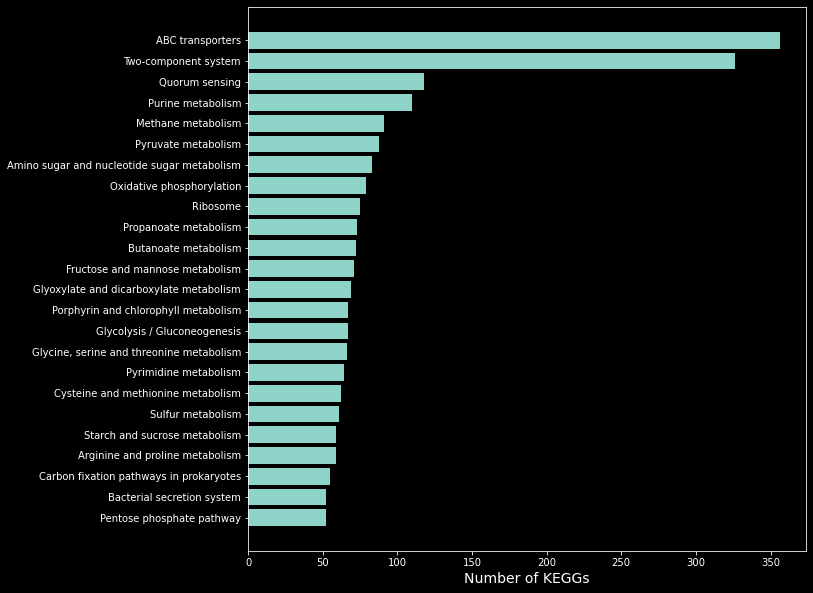

In [41]:
# Visualize KEGG counts for shotgun metagenomics data
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 10))
    pwy_counts = sig_pths['Name']
    pwy_counts = pwy_counts.value_counts()
    pwy_counts = pwy_counts.sort_values(ascending=True)
    # only focus on highly representive pathways
    pwy_counts = pwy_counts.loc[pwy_counts > 50] 
    ax.barh(pwy_counts.index, pwy_counts.values)
    ax.set_xlabel('Number of KEGGs', fontsize=14)

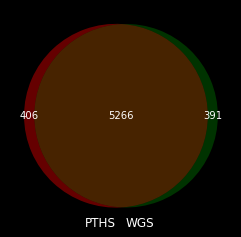

In [42]:
# Venn diagram to visualize overlap
with plt.style.context('dark_background'):
    venn2([set(kegg_asd_pths['KEGG']), 
           set(kegg_asd_wgs['KEGG'])], 
          set_labels=['PTHS', 'WGS'])

# PTHS unique KEGGs

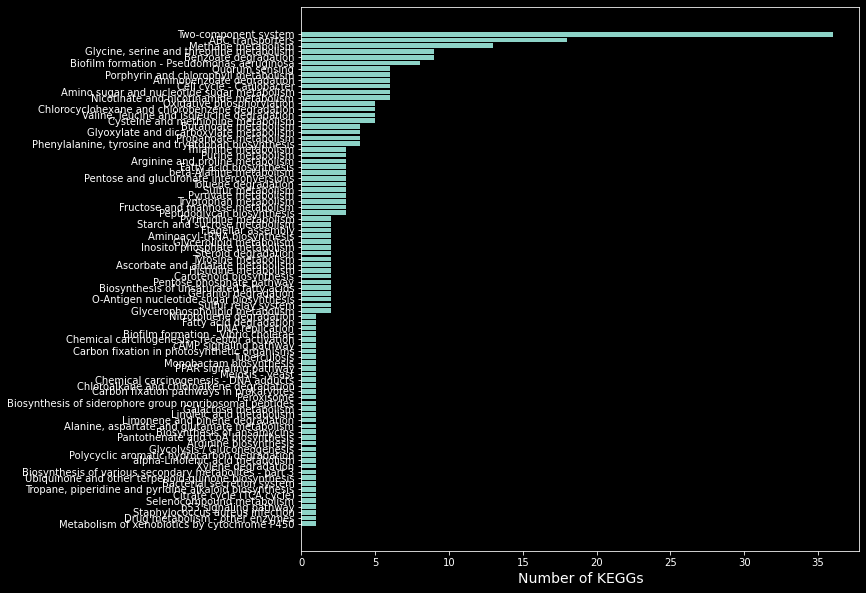

In [43]:
# Visualize KEGG counts for shotgun metagenomics data
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 10))
    uniq = set(sig_pths['KO']) - set(sig_wgs['KO'])
    idx = sig_pths.apply(lambda x: x['KO'] in uniq, axis=1)
    pwy_counts = sig_pths.loc[idx, 'Name']
    pwy_counts = pwy_counts.value_counts()
    pwy_counts = pwy_counts.sort_values(ascending=True)
    # only focus on highly representive pathways
    pwy_counts = pwy_counts.loc[pwy_counts > 0] 
    ax.barh(pwy_counts.index, pwy_counts.values)
    ax.set_xlabel('Number of KEGGs', fontsize=14)

# Combined unique KEGGs

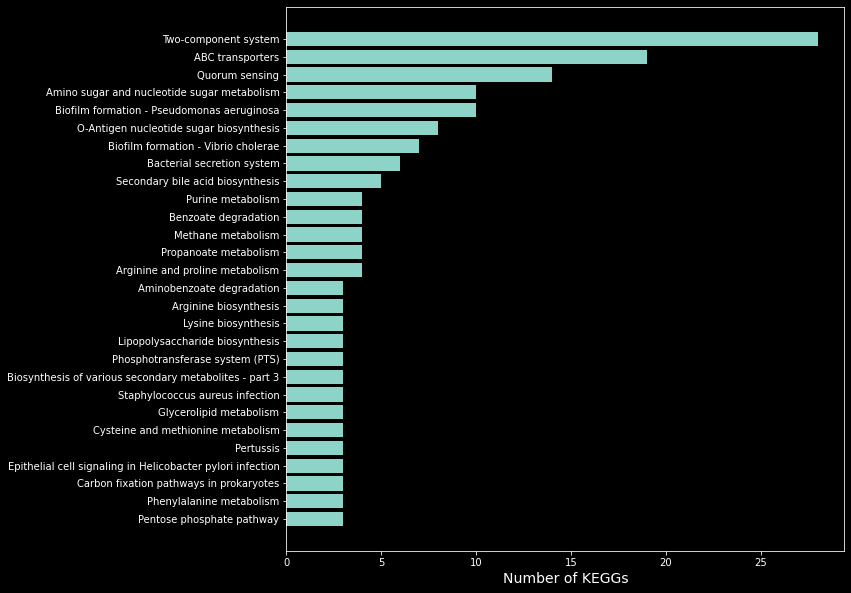

In [44]:
# Visualize KEGG counts for shotgun metagenomics data
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(10, 10))
    uniq = set(sig_wgs['KO']) - set(sig_pths['KO'])
    idx = sig_wgs.apply(lambda x: x['KO'] in uniq, axis=1)
    pwy_counts = sig_wgs.loc[idx, 'Name']
    pwy_counts = pwy_counts.value_counts()
    pwy_counts = pwy_counts.sort_values(ascending=True)
    # only focus on highly representive pathways
    pwy_counts = pwy_counts.loc[pwy_counts > 2] 
    ax.barh(pwy_counts.index, pwy_counts.values)
    ax.set_xlabel('Number of KEGGs', fontsize=14)

# Pairwise WGS analysis

In [45]:
dan_fname = '../sfari/data/sra_shotgun/Dan2020/age_sex_matched_posterior/ogus_differentials-v2.nc'
wang_fname = '../sfari/data/sra_shotgun/Wang2021/age_sex_matched_posterior/ogus_differentials-v2.nc'
averina_fname = '../sfari/data/sra_shotgun/Averina2020/age_sex_matched_posterior/ogus_differentials-v2.nc'

dan_diffs = extract_differentials(dan_fname)
wang_diffs = extract_differentials(wang_fname)
averina_diffs = extract_differentials(averina_fname)

dan_stats = ranking(dan_diffs, reference_percentile=90)
wang_stats = ranking(wang_diffs, reference_percentile=90)
averina_stats = ranking(averina_diffs, reference_percentile=90)

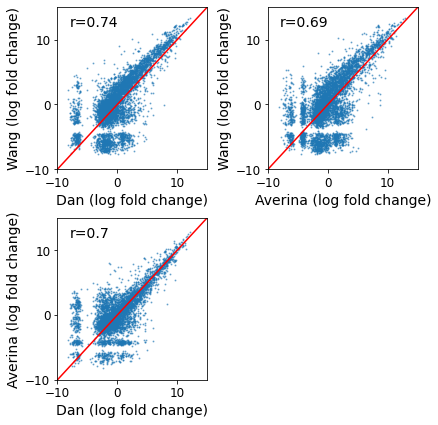

In [48]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(2, 2, figsize=(6, 6))
common_taxa = list(set(dan_stats.index) & set(wang_stats.index))
ax[0, 0].scatter(dan_stats.loc[common_taxa, 'mean'], 
                 wang_stats.loc[common_taxa, 'mean'], 
                 alpha=0.5, s=1)
ax[0, 0].set_xlabel('Dan (log fold change)', fontsize=14)
ax[0, 0].set_ylabel('Wang (log fold change)', fontsize=14)
ax[0, 0].tick_params(axis='x', labelsize=12)
ax[0, 0].tick_params(axis='y', labelsize=12)
r = pearsonr(dan_stats.loc[common_taxa, 'mean'], wang_stats.loc[common_taxa, 'mean'])    
ax[0, 0].annotate(f'r={np.round(r[0], 2)}', xy=(-8, 12), fontsize=14)
ax[0, 0].set_xlim([-10, 15])
ax[0, 0].set_ylim([-10, 15])
ax[0, 0].plot(np.linspace(-10, 15), np.linspace(-10, 15), c='r')
ax[0, 0].yaxis.set_major_locator(MaxNLocator(3)) 

common_taxa = list(set(dan_stats.index) & set(averina_stats.index))
ax[1, 0].scatter(dan_stats.loc[common_taxa, 'mean'], 
                 averina_stats.loc[common_taxa, 'mean'], 
                 alpha=0.5, s=1)
ax[1, 0].set_xlabel('Dan (log fold change)', fontsize=14)
ax[1, 0].set_ylabel('Averina (log fold change)', fontsize=14)
ax[1, 0].tick_params(axis='x', labelsize=12)
ax[1, 0].tick_params(axis='y', labelsize=12)
r = pearsonr(dan_stats.loc[common_taxa, 'mean'], averina_stats.loc[common_taxa, 'mean'])    
ax[1, 0].annotate(f'r={np.round(r[0], 2)}', xy=(-8, 12), fontsize=14)
ax[1, 0].set_xlim([-10, 15])
ax[1, 0].set_ylim([-10, 15])
ax[1, 0].plot(np.linspace(-10, 15), np.linspace(-10, 15), c='r')
ax[1, 0].yaxis.set_major_locator(MaxNLocator(3)) 

common_taxa = list(set(wang_stats.index) & set(averina_stats.index))
ax[0, 1].scatter(averina_stats.loc[common_taxa, 'mean'], 
                 wang_stats.loc[common_taxa, 'mean'], 
                 alpha=0.5, s=1)
ax[0, 1].set_xlabel('Averina (log fold change)', fontsize=14)
ax[0, 1].set_ylabel('Wang (log fold change)', fontsize=14)
ax[0, 1].tick_params(axis='x', labelsize=12)
ax[0, 1].tick_params(axis='y', labelsize=12)
r = pearsonr(averina_stats.loc[common_taxa, 'mean'], wang_stats.loc[common_taxa, 'mean'])    
ax[0, 1].annotate(f'r={np.round(r[0], 2)}', xy=(-8, 12), fontsize=14)
ax[0, 1].set_xlim([-10, 15])
ax[0, 1].set_ylim([-10, 15])
ax[0, 1].plot(np.linspace(-10, 15), np.linspace(-10, 15), c='r')
ax[0, 1].yaxis.set_major_locator(MaxNLocator(3)) 

ax[1, 1].axis('off')
plt.tight_layout()

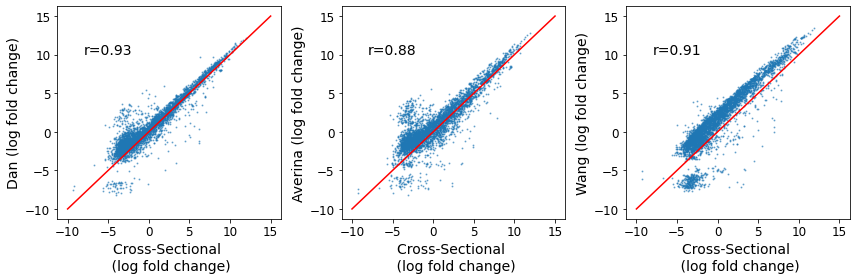

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
common_taxa = list(set(dan_stats.index) & set(wgs_stats.index))
ax[0].scatter(wgs_stats.loc[common_taxa, 'mean'],
              dan_stats.loc[common_taxa, 'mean'], 
              alpha=0.5, s=1)
ax[0].set_ylabel('Dan (log fold change)', fontsize=14)
ax[0].set_xlabel('Cross-Sectional \n (log fold change)', fontsize=14)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)
r = pearsonr(dan_stats.loc[common_taxa, 'mean'], wgs_stats.loc[common_taxa, 'mean'])    
ax[0].annotate(f'r={np.round(r[0], 2)}', xy=(-8, 10), fontsize=14)
ax[0].plot(np.linspace(-10, 15), np.linspace(-10, 15), c='r')

common_taxa = list(set(wgs_stats.index) & set(averina_stats.index))
ax[1].scatter(wgs_stats.loc[common_taxa, 'mean'], 
              averina_stats.loc[common_taxa, 'mean'], 
              alpha=0.5, s=1)
ax[1].set_ylabel('Averina (log fold change)', fontsize=14)
ax[1].set_xlabel('Cross-Sectional \n (log fold change)', fontsize=14)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
r = pearsonr(averina_stats.loc[common_taxa, 'mean'], wgs_stats.loc[common_taxa, 'mean'])    
ax[1].annotate(f'r={np.round(r[0], 2)}', xy=(-8, 10), fontsize=14)
ax[1].plot(np.linspace(-10, 15), np.linspace(-10, 15), c='r')

common_taxa = list(set(wang_stats.index) & set(wgs_stats.index))
ax[2].scatter(wgs_stats.loc[common_taxa, 'mean'], 
              wang_stats.loc[common_taxa, 'mean'], 
              alpha=0.5, s=1)
ax[2].set_ylabel('Wang (log fold change)', fontsize=14)
ax[2].set_xlabel('Cross-Sectional \n (log fold change)', fontsize=14)
ax[2].tick_params(axis='x', labelsize=12)
ax[2].tick_params(axis='y', labelsize=12)
r = pearsonr(wang_stats.loc[common_taxa, 'mean'], wgs_stats.loc[common_taxa, 'mean'])    
ax[2].annotate(f'r={np.round(r[0], 2)}', xy=(-8, 10), fontsize=14)
ax[2].plot(np.linspace(-10, 15), np.linspace(-10, 15), c='r')
#ax[2].axis('off')
plt.tight_layout()

In [ ]:
def residual_skewtest(A_diffs, B_diffs):
    common_taxa = list(set(A_diffs.index) & set(B_diffs.index))
    A_diffs_aligned = A_diffs.loc[common_taxa]
    B_diffs_aligned = B_diffs.loc[common_taxa]
    A_clr_diffs = A_diffs - A_diffs_aligned.mean(axis=0)
    B_clr_diffs = B_diffs - B_diffs_aligned.mean(axis=0)
    A_B_diffs = A_diffs_aligned - B_diffs_aligned
    A_B_stats = ranking(A_B_diffs, reference_percentile=95)
    return skewtest(A_B_diffs.values.ravel())

In [ ]:
print('PTHS', residual_skewtest(pths_stats, wgs_stats))
print('Dan', residual_skewtest(dan_stats, wgs_stats))
print('Averina', residual_skewtest(averina_stats, wgs_stats))
print('Wang', residual_skewtest(wang_stats, wgs_stats))

In [ ]:
def residual_skewtest(A_diffs, B_diffs):
    common_taxa = list(set(A_diffs.index) & set(B_diffs.index))
    A_diffs_aligned = A_diffs.loc[common_taxa]
    B_diffs_aligned = B_diffs.loc[common_taxa]
    A_clr_diffs = A_diffs - A_diffs_aligned.mean(axis=0)
    B_clr_diffs = B_diffs - B_diffs_aligned.mean(axis=0)
    A_B_diffs = A_diffs_aligned - B_diffs_aligned
    A_B_stats = ranking(A_B_diffs, reference_percentile=95)
    return skewtest(A_B_diffs['mean'].ravel())

In [ ]:
print('PTHS', residual_skewtest(pths_stats, wgs_stats))
print('Dan', residual_skewtest(dan_stats, wgs_stats))
print('Averina', residual_skewtest(averina_stats, wgs_stats))
print('Wang', residual_skewtest(wang_stats, wgs_stats))

In [ ]:
common_taxa = list(set(dan_stats.index) & set(pths_stats.index))
fig, ax = plt.subplots()
ax.scatter(dan_stats.loc[common_taxa, 'mean'], 
           pths_stats.loc[common_taxa, 'mean'], 
           alpha=0.5, s=1)

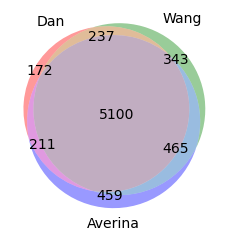

In [50]:
# Venn diagram to visualize overlap
out = venn3([set(dan_stats.index), 
       set(wang_stats.index),
       set(averina_stats.index)], 
      set_labels=['Dan', 'Wang', 'Averina'])
for text in out.set_labels:
    text.set_fontsize(14)
for text in out.subset_labels:
    text.set_fontsize(14)

In [ ]:
# Plot the log-fold changes
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(7, 3))
    rankplot(dan_stats, ax)
    ax.set_title('Dan Taxa Differentials', 
                    fontsize=18)
    ax.set_xlabel('Taxa', fontsize=18)
    plt.tight_layout()

In [ ]:
sns.distplot(dan_stats['mean'])

# Dan debug

In [ ]:
!ls ../sfari/data/sra_shotgun/Dan2020/bioms

In [ ]:
dan_dir = '../sfari/data/sra_shotgun/Dan2020/bioms'
ogu_file = f'{dan_dir}/ogus-corrected.biom'
table = biom.load_table(ogu_file)

In [ ]:
np.sum(table.data(id='1111121', axis='observation') > 0)

In [ ]:
np.sum(table.data(id='102125', axis='observation') > 0)

In [ ]:
np.sum(table.data(id='102106', axis='observation') > 0)

In [ ]:
plt.plot(np.sort(table.data(id='189426', axis='observation')))